In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
# source: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
imsize = (700, 800)

In [4]:
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

In [6]:
style_img = image_loader("la_nuit_etoile.jpg")
content_img = image_loader("content_cat.png")

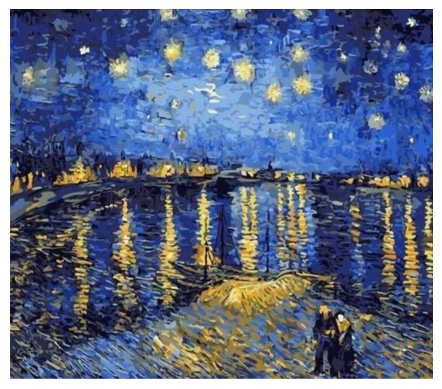

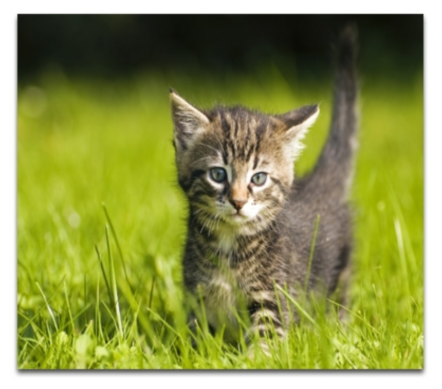

In [7]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor):
    image = tensor.clone().detach()
    image = image.squeeze(0)
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    plt.pause(0.001)


plt.figure()
imshow(style_img)

plt.figure()
imshow(content_img)

In [8]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = 0

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()
        self.loss = 0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)

In [12]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3']


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [14]:
def get_style_model_and_losses(
        cnn, normalization_mean, normalization_std,
        style_img,
        content_img,
        content_layers=content_layers_default,
        style_layers=style_layers_default
):
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [15]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [16]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=350,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)
    all_style_score, all_content_score = [], []
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                imshow(input_img)
                all_style_score.append(style_score)
                all_content_score.append(content_score)

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, all_style_score, all_content_score

Building the style transfer model..
Optimizing..


C:\Users\thorr\AppData\Local\Temp\ipykernel_564\1224953384.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\thorr\AppData\Local\Temp\ipykernel_564\1224953384.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 16.513044 Content Loss: 15.233039


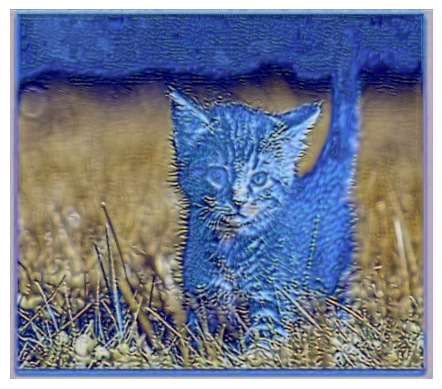

run [100]:
Style Loss : 2.069852 Content Loss: 10.326245


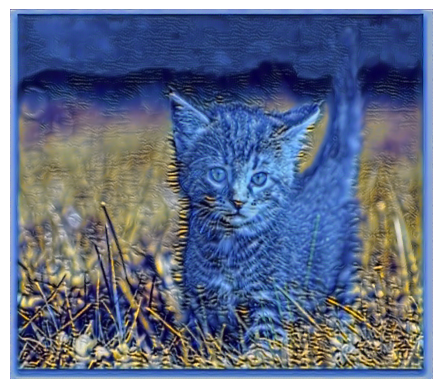

run [150]:
Style Loss : 1.048136 Content Loss: 8.856780


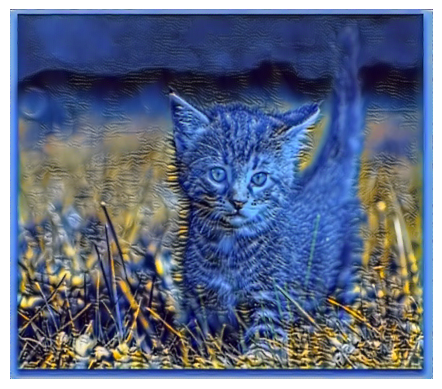

run [200]:
Style Loss : 0.941424 Content Loss: 8.253631


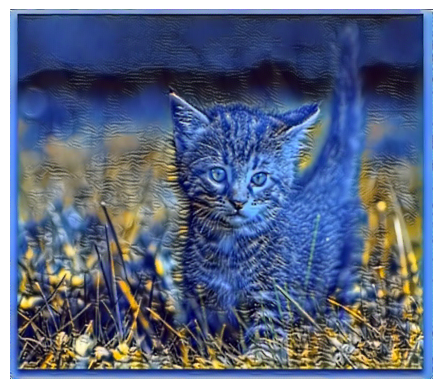

run [250]:
Style Loss : 0.937983 Content Loss: 7.942250


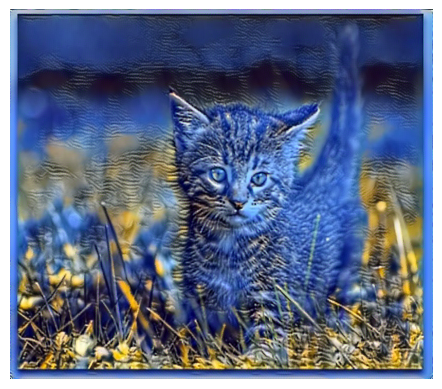

run [300]:
Style Loss : 0.918379 Content Loss: 7.805598


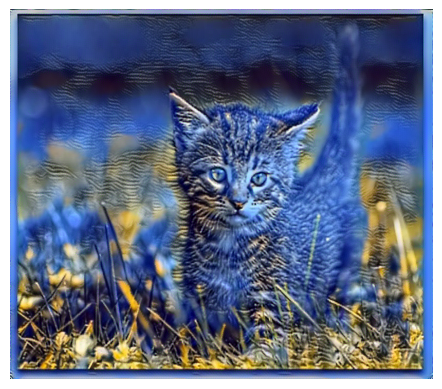

run [350]:
Style Loss : 0.977470 Content Loss: 7.702580


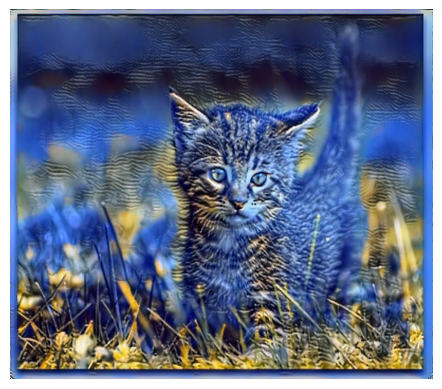

In [17]:
input_img, style_score, content_score = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, content_img)


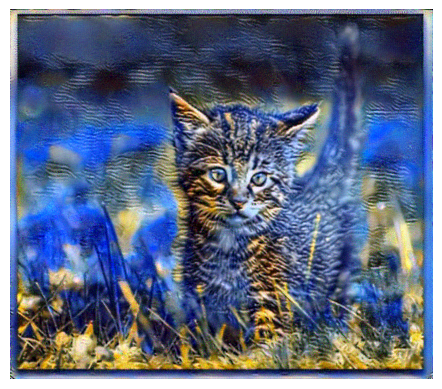

In [18]:
imshow(input_img)
#plt.savefig("test.png")

In [ ]:
style_score_cpu = [score.cpu().item() for score in style_score]
content_score_cpu = [score.cpu().item() for score in content_score]

plt.plot(range(len(style_score_cpu)), style_score_cpu, c="red", label="Style loss")
plt.plot(range(len(content_score_cpu)), content_score_cpu, c="blue", label="Content loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()